# Media Slant and Text Analysis - EUI, December 2020

This notebook aims to replicate parts of the text analysis performed in the seminal 2010 paper written by Matthew Gentzkow and Jesse Shapiro and published in Econometrica. A link to the article can be found [here](https://web.stanford.edu/~gentzkow/research/biasmeas.pdf).

The paper analyzes the selective use of **ideologically-charged language** in media and its connection with political preferences by readers and owners alike. Crucially for us, in it the authors use natural language processing techniques hitherto scarcely used by economists. In particular, Gentzkow and Shapiro construct measures of slant based on language similarity between the lexicon used by over 400 national newspapers in the USA and the one used by politicians both sides of the aisle.

The **methodology** used by the authors can be best summarized as follows: 

- Consider official speeches by US congresspeople
- Identify the bi-grams and tri-grams most representative of Republicans and Democrats
- Compute the relative frequency of Democratic and Republican expressions in the articles published in over 400 newspapers
- Define the slant of each newspaper with respect to politicians
- Test whether slant is driven by consumers' vs. owners' preferences

The main **findings** can be succinctly summed up as:
- Slant highly correlates with political leaning of potential readers
- Identity of media owner does not explain much

## Python Script

In [1]:
# Load packages

# Basics
import re                                                               # built-in regular expressions
import os                                                               # built-in operating system interfaces
import numpy as np                                                      # for everything matrix-related
import pandas as pd                                                     # data manipulation and analysis
pd.set_option('display.max_columns', None)                              # Show all columns on display

# nltk
import nltk                                                             # Natural language Toolkit
from nltk.stem import SnowballStemmer                                   # Porter's II Stemmer
from nltk import word_tokenize                                          # Document tokenizer
from nltk.corpus import stopwords                                       # Importing stopwords

# Plotting
import matplotlib.pyplot as plt                                         # Plotting library
import seaborn as sns                                                   # High-end plotting based on matplotlib
from wordcloud import WordCloud                                         # Visualize word frequencies

# sklearn
from sklearn.feature_extraction.text import CountVectorizer             # Convert raw documents to frequency matrix of features
from sklearn.feature_selection import chi2                              # Chi-squared stats
from sklearn.linear_model import LinearRegression                       # Linear regression model

# Misc
from tqdm import tqdm                                                   # Progress bar for loops

In [2]:
# Define Directory - Change accordingly
maindir = 'E:/Dropbox/_Pre-Doc/NLP_course/template/02_GentzkowShapiro2010/'
datadir = maindir + 'data/'
np_data = datadir + 'NewsLibrary/'
results = maindir + 'results/'

## Data
- <font color='blue'>Politicians</font>
    - All speeches from the 2005 *Congressional Record*
    - Ideological score: vote share to Bush in the 2004 presidential election in a given congressperson's constituency

- <font color='blue'>News content</font>
    - Headlines and text of all articles published on 433 US daily newspapers in 2005
    - Source: NewsLibrary, ProQuest
    - Only news articles, no editorials
    
- <font color='blue'>Other</font>
    - Newspaper HQ location and relevant market (MSA)
    - Vote shares for Republicans and Democrats in relevant media market
    - Identity of newspaper's owner

## Methodology: Step #1

- Pre-process the _Congressional Record_ corpus: remove stop words, stemming (Porter)
- Consider all 2-word and 3-word phrases appearing in the corpus
- For each phrase _p_ of length _l_, compute the total number of times it is used by Democrats and Republicans $\big($<font color='blue'>$f_{pld}$</font>,<font color='blue'>$f_{plr}$</font>$\big)$
- For each phrase compute the Pearson's $\chi^2$ statistic:

$$
\chi_{p l}^{2}=\frac{\left(f_{p l r} f_{\sim p l d}-f_{p l d} f_{\sim p l r}\right)^{2}}{\left(f_{p l r}+f_{p l d}\right)\left(f_{p l r}+f_{\sim p l r}\right)\left(f_{p l d}+f_{\sim p l d}\right)\left(f_{\sim p l r}+f_{\sim p l d}\right)}
$$

- $\chi^2$: test statistic for the null hypothesis that the propensity to use phrase $p$ is equal for Democrats and Republicans
- Simple to compute, only requires $f_{pld}$ and $f_{plr}$. Preferable to other naive statistics such as the ratio of uses by D or R

### Preprocessing Congressional Speeches

The code below uses somewhat different data from the one used by the authors. Including in this replication are over 1,700 Congresspeople immigration-based speeches, given between 2009 and 2016. Instead of using percentage of constituency vote that went for Bush, we will simply use Congresspeople's party memberships. The implications of these discretionary decisions on the pedagogic purposes of this code are negligible.

We will first load the data and run some checks, before implementing all tasks highlighted in <font color='blue'>step #1</font>

In [3]:
# Load in the Congressional speech dataset
speech_df = pd.read_excel(datadir + '__Congressional_speech_Imm.xlsx')

#### Checks

In [4]:
# Inspect the size of our dataset
print(speech_df.shape)

# Duplicates
print('Duplicated speech entries:', speech_df.duplicated().any())

(1710, 24)
Duplicated speech entries: False


In [5]:
# Overview of variable types
print('Document column names & types:\n\n', speech_df.dtypes)

# Check first handful of entries
speech_df.head()

Document column names & types:

 congress                      int64
speaker                      object
future_districtID            object
speech_id                     int64
speakerid                     int64
lastname                     object
firstname                    object
chamber                      object
state                        object
gender                       object
party                        object
district                      int64
speech                       object
num_imm_C                     int64
num_illimm_C                  int64
date                 datetime64[ns]
districtID                   object
speaker_                     object
districtID_                  object
party_                       object
gender_                      object
state_                       object
chamber_                     object
year                          int64
dtype: object


,congress,speaker,future_districtID,speech_id,speakerid,lastname,firstname,chamber,state,gender,party,district,speech,num_imm_C,num_illimm_C,date,districtID,speaker_,districtID_,party_,gender_,state_,chamber_,year
0,113,BILL_FOSTER_D_IL,113_IL_11,1130046967,113121930,FOSTER,BILL,H,IL,M,D,11,mr. speaker. i am pleased to rise today to hig...,1,0,2013-09-18,113_IL_11,BILL_FOSTER_D_IL,113_IL_11,D,M,IL,H,2013
1,111,BOBBY_RUSH_D_IL,111_IL_1,1110077051,111121150,RUSH,BOBBY,H,IL,M,D,1,madam speaker. i rise in solidarity with my co...,1,0,2010-01-20,111_IL_1,BOBBY_RUSH_D_IL,111_IL_1,D,M,IL,H,2010
2,114,BRIAN_BABIN_R_TX,114_TX_36,1140072045,114123270,BABIN,BRIAN,H,TX,M,R,36,mr. speaker. for months americans have been de...,1,0,2016-01-08,114_TX_36,BRIAN_BABIN_R_TX,114_TX_36,R,M,TX,H,2016
3,114,DOUG_COLLINS_R_GA,114_GA_9,1140011523,114122170,COLLINS,DOUG,H,GA,M,R,9,mr. speaker. i rise today in support of a rule...,1,1,2015-02-27,114_GA_9,DOUG_COLLINS_R_GA,114_GA_9,R,M,GA,H,2015
4,113,HENRY_JOHNSON_D_GA,113_GA_4,1130006545,113119960,JOHNSON,HENRY,H,GA,M,D,4,today. madam speaker. i rise in opposition to ...,1,0,2013-02-28,113_GA_4,HENRY_JOHNSON_D_GA,113_GA_4,D,M,GA,H,2013


In [6]:
# Check for column-specific NaNs
cols = speech_df.columns.to_list()
for col in cols:
    print('Nb of NaNs in col', col, 'is:', speech_df[col].isnull().sum())

Nb of NaNs in col congress is: 0
Nb of NaNs in col speaker is: 0
Nb of NaNs in col future_districtID is: 0
Nb of NaNs in col speech_id is: 0
Nb of NaNs in col speakerid is: 0
Nb of NaNs in col lastname is: 0
Nb of NaNs in col firstname is: 0
Nb of NaNs in col chamber is: 0
Nb of NaNs in col state is: 0
Nb of NaNs in col gender is: 0
Nb of NaNs in col party is: 0
Nb of NaNs in col district is: 0
Nb of NaNs in col speech is: 0
Nb of NaNs in col num_imm_C is: 0
Nb of NaNs in col num_illimm_C is: 0
Nb of NaNs in col date is: 0
Nb of NaNs in col districtID is: 0
Nb of NaNs in col speaker_ is: 0
Nb of NaNs in col districtID_ is: 0
Nb of NaNs in col party_ is: 0
Nb of NaNs in col gender_ is: 0
Nb of NaNs in col state_ is: 0
Nb of NaNs in col chamber_ is: 0
Nb of NaNs in col year is: 0


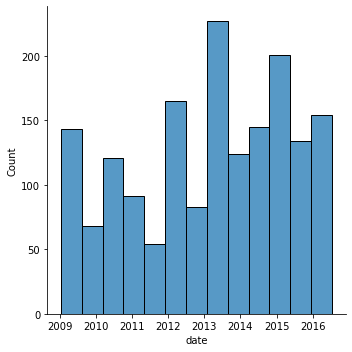

In [7]:
# Histogram plot
sns.displot(speech_df, x="date")

#### - Pre-process the _Congressional Record_ corpus: remove stop words, stemming (Porter)

In [8]:
# The first speech in our dataset
speech_df['speech'][0]

'mr. speaker. i am pleased to rise today to highlight the many important contributions that immigrants make to our nation and our economy. to our scientific progress. and to say a few special words on the positive impact that comprehensive immigration reform will have on the real estate market in our country. we are a nation of immigrants. many of us are second- or thirdgeneration americans. and we have all benefited from the sacrifices that our ancestors made in search of a better life in america. in fact. my wife is a firstgeneration asianamerican who came to the united states to pursue her education. and was able to become a legal immigrant and a citizen and a ph.d.. in fact. but who knows that even our legal immigration system does not work as well as it should. every day. families come to this country in search of the american dreambetter jobs. better education. and a better life for their families. i am proud to represent many of these families. but would like to share just one i

In [9]:
# Pre-processing steps
remove_punct = str.maketrans('','','!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”’')
stop_words   = stopwords.words('english')
stop_words.append('speaker')
stemmer      = SnowballStemmer('english')

In [10]:
# Pre-processing function
def normalize_text(doc):
    """Takes documents as input and outputs clean tokens"""
    
    doc        = doc.replace('</br>', ' ')
    lower      = doc.lower()                                             # all lower case
    nopunc     = lower.translate(remove_punct)                           # remove punctuation
    words      = nopunc.split()                                          # split into tokens
    nostop     = [w for w in words if w not in stop_words]               # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop]         # normalize numbers
    stem_text  = [stemmer.stem(w) for w in no_numbers]                   # stem each word
    
    return stem_text

In [11]:
# Pass all statements through the pre-processing function
speeches = []                                                            # Create list to feed

for x in tqdm(speech_df['speech']):                                      # Iterate over each speech
    
    raw_wip = normalize_text(x)                                          # Call in normalize_text function on doc
    speeches.append(raw_wip)                                             # Append to list

100%|██████████████████████████████████████████████████████████████████████████████| 1710/1710 [00:18<00:00, 92.46it/s]


In [12]:
# The same first speech in our dataset, after pre-processing
print(speeches[0])

['mr', 'pleas', 'rise', 'today', 'highlight', 'mani', 'import', 'contribut', 'immigr', 'make', 'nation', 'economi', 'scientif', 'progress', 'say', 'special', 'word', 'posit', 'impact', 'comprehens', 'immigr', 'reform', 'real', 'estat', 'market', 'countri', 'nation', 'immigr', 'mani', 'us', 'second', 'thirdgener', 'american', 'benefit', 'sacrific', 'ancestor', 'made', 'search', 'better', 'life', 'america', 'fact', 'wife', 'firstgener', 'asianamerican', 'came', 'unit', 'state', 'pursu', 'educ', 'abl', 'becom', 'legal', 'immigr', 'citizen', 'phd', 'fact', 'know', 'even', 'legal', 'immigr', 'system', 'work', 'well', 'everi', 'day', 'famili', 'come', 'countri', 'search', 'american', 'dreambett', 'job', 'better', 'educ', 'better', 'life', 'famili', 'proud', 'repres', 'mani', 'famili', 'would', 'like', 'share', 'one', 'incred', 'stori', 'one', 'constitu', 'juventino', 'cano', 'grow', 'juventino', 'live', 'farm', 'colima', 'mexico', 'parent', 'six', 'brother', 'sister', 'home', 'didnt', 'light

In [13]:
# Create cleaned documents
speech_clean = [" ".join(text) for text in speeches]          # Convert each speech string-list to a single string

print('Corpus type:',               type(speech_clean))
print('Length of corpus:',          len(speech_clean))
print('Speech type:',               type(speech_clean[0]))
print('First speech in dataset:\n', speech_clean[0])

# Create additional column in the speeches DF that is the pre-processed speeches
speech_df["preproc_speech"] = speech_clean

Corpus type: <class 'list'>
Length of corpus: 1710
Speech type: <class 'str'>
First speech in dataset:
 mr pleas rise today highlight mani import contribut immigr make nation economi scientif progress say special word posit impact comprehens immigr reform real estat market countri nation immigr mani us second thirdgener american benefit sacrific ancestor made search better life america fact wife firstgener asianamerican came unit state pursu educ abl becom legal immigr citizen phd fact know even legal immigr system work well everi day famili come countri search american dreambett job better educ better life famili proud repres mani famili would like share one incred stori one constitu juventino cano grow juventino live farm colima mexico parent six brother sister home didnt light electr work long hour famili farm make end meet # year old stepbroth encourag come aurora illinoi told wonder opportun await america abl get job stepbroth packag compani # juventino held steadi job learn engli

####  - Consider all 2-word and 3-word phrases appearing in the corpus

The code snippets below transform the collection of pre-processed speeches above to a matrix of TF-IDF features. It then computes chi-squared statistics for all features and the relative use by Republicans vs. Democrats. These are used to filter out most features and obtain only those that are most reflective of ideological slant by political agents. 

In [14]:
#Get the term-document matrix of bi-grams
tvec_bi = CountVectorizer(analyzer  = 'word',      # Arg: feature as word (use analyzer to collapse all steps in the future!)
                       ngram_range  = (2, 2),      # Arg: a range of n-grams to extract as features 
                       stop_words   = None,        # Arg: stopwords (already removed above)
                       encoding     = "utf-8",     # Arg: Variable-width encoding
                       decode_error = "replace",   # Arg: Instruction to deal with non-UTF-8
                       max_features = 10000,       # Arg: Maximum number of features
                       min_df       = 1e-2,        # Arg: Minimum frequency of words-features
                       max_df       = 0.9          # Arg: Maximum frequency of words-features
                      )

# Train and transform 
data_ctvec_bi = tvec_bi.fit_transform(speech_clean)     # Note: In sklearn, most models require fitting (train parameters) using data.
                                                  # To actually pass the model and transform the data, you need to 'transform'

# Output in dense format
X_mat = data_ctvec_bi.todense()

# Store word names
words_bi = tvec_bi.get_feature_names()  

# Data snippet
x_df_bi = pd.DataFrame(X_mat)
x_df_bi.columns = words_bi
x_df_bi.head()

21st centuri  abl get  abl work  abraham lincoln  access health  \
0             0        1         0                0              0   
1             0        0         0                0              0   
2             0        0         0                0              0   
3             0        0         0                0              0   
4             0        0         0                0              0   

   across aisl  across america  across board  across border  across countri  \
0            0               0             0              0               0   
1            0               0             0              0               0   
2            0               0             0              0               0   
3            0               0             0              0               0   
4            0               0             0              0               0   

   across nation  across southern  across state  across unit  across world  \
0              0                0             0            0             0   
1              0                0             0            0             0   
2              0                0             0            0             0   
3              0                0             0            0             0   
4              0                0             0            0             0   

   act bill  act chair  act pass  act presid  act would  action childhood  \
0         0          0         0           0          0                 0   
1         0          0         0           0          0                 0   
2         0          0         0           0          0                 0   
3         0          0         0           0          0                 0   
4         0          0         0           0          0                 0   

   action immigr  action presid  action taken  address broken  address floor  \
0              0              0             0               0              0   
1              0              0             0               0              0   
2              0              0             0               0              0   
3              1              0             0               0              0   
4              0              0             0               0              0   

   address immigr  address issu  address problem  administr say  \
0               0             0                0              0   
1               0             0                0              0   
2               0             0                0              0   
3               0             0                0              0   
4               0             0                0              0   

   administr would  afford care  african american  air forc  al qaeda  \
0                0            0                 0         0         0   
1                0            0                 0         0         0   
2                0            0                 0         0         0   
3                0            0                 0         0         0   
4                0            0                 0         0         0   

   allow peopl  allow state  allow us  allow vote  almost everi  almost year  \
0            0            0         0           0             0            0   
1            0            0         0           0             0            0   
2            0            0         0           0             0            0   
3            0            0         0           0             0            0   
4            0            0         0           0             0            0   

   along border  along way  also includ  also know  also like  also make  \
0             0          0            0          0          0          0   
1             0          0            0          0          0          0   
2             0          0            0          0          0          0   
3             0          0            0          0          0      

#### - For each phrase _p_ of length _l_, compute the total number of times it is used by Democrats and Republicans $\big($<font color='blue'>$f_{pld}$</font>,<font color='blue'>$f_{plr}$</font>$\big)$

In [15]:
# Obtain phrases more frequently used by Republicans vs. Democrat and viceversa
x_df_bi['party'] = speech_df['party']
pp = x_df_bi.groupby('party').sum().idxmax(axis = 0).reset_index(name = 'party').to_numpy()

print('More frequently used Republican bi-gram phrases:', pp[:,1].tolist().count('R'))
print('More frequently used Democrat bi-gram phrases:',   pp[:,1].tolist().count('D'))

More frequently used Republican bi-gram phrases: 951
More frequently used Democrat bi-gram phrases: 881


#### - For each phrase compute the Pearson's $\chi^2$ statistic:

$$
\chi_{p l}^{2}=\frac{\left(f_{p l r} f_{\sim p l d}-f_{p l d} f_{\sim p l r}\right)^{2}}{\left(f_{p l r}+f_{p l d}\right)\left(f_{p l r}+f_{\sim p l r}\right)\left(f_{p l d}+f_{\sim p l d}\right)\left(f_{\sim p l r}+f_{\sim p l d}\right)}
$$

In [16]:
# Define boolean mask for whether the speaker is a member of the Republican party
mask = (x_df_bi['party'] == 'R')

#Compute the chi-2 statistic between the bi-grams and the party affiliation of congressmembers
chi2score = chi2(data_ctvec_bi, mask)[0] # Get the first array returned by the chi2 function, i.e. the chi-2 statistics of each association

print('bi-gram chi2scores:',type(chi2score), len(chi2score), type(chi2score[0]))

bi-gram chi2scores: <class 'numpy.ndarray'> 1832 <class 'numpy.float64'>


#### - $\chi^2$: test statistic for the null hypothesis that the propensity to use phrase $p$ is equal for Democrats and Republicans

In [17]:
# Order the top chi-2
wscores = list(zip(tvec_bi.get_feature_names(), chi2score, pp[:,1])) # Create a list of (phrase, chiscore, party) tuples
print('Length of chi-square scores:',len(wscores))

wchi2   = sorted(wscores, key=lambda x:x[1])               # Sort the list according to the chiscore

# Retrieve the list of R-D words. Returns the list of pairs
topchi2 = list(zip(*wchi2))                       

#Create a DF with phrases and their respective chi2 score.
phrases_bi = pd.DataFrame({'phrase':list(topchi2[0]), 'chi2':list(topchi2[1]), 'party': list(topchi2[2])})

# Save phrases
phrases_bi.to_csv(datadir + 'speech_biphrases.csv', index=False)

Length of chi-square scores: 1832


#### Repeat for 3-gram phrases

In [18]:
#Get the term-document matrix of tri-grams
tvec_tri = CountVectorizer(analyzer = 'word',      # Arg: feature as word (use analyzer to collapse all steps in the future!)
                       ngram_range  = (3, 3),      # Arg: a range of n-grams to extract as features 
                       stop_words   = None,        # Arg: stopwords (already removed above)
                       encoding     = "utf-8",     # Arg: Variable-width encoding
                       decode_error = "replace",   # Arg: Instruction to deal with non-UTF-8
                       max_features = 10000,       # Arg: Maximum number of features
                       min_df       = 5e-3,        # Arg: Minimum frequency of words-features
                       max_df       = 0.9          # Arg: Maximum frequency of words-features
                      )

# Train and transform 
data_ctvec_tri = tvec_tri.fit_transform(speech_clean)  # Note: In sklearn, most models require fitting (train parameters) using data.
                                                       # To actually pass the model and transform the data, you need to 'transform'

# Output in dense format
X_mat = data_ctvec_tri.todense()

# Store word names
words_tri = tvec_tri.get_feature_names()  

# Data snippet
x_df_tri = pd.DataFrame(X_mat)
x_df_tri.columns = words_tri
x_df_tri.head()

# Obtain phrases more frequently used by Republicans vs. Democrat and viceversa
x_df_tri['party'] = speech_df['party']
pp = x_df_tri.groupby('party').sum().idxmax(axis = 0).reset_index(name = 'party').to_numpy()

print('More frequently used Republican tri-gram phrases:', pp[:,1].tolist().count('R'))
print('More frequently used Democrat tri-gram phrases:',   pp[:,1].tolist().count('D'))

# Define boolean mask for whether the speaker is a member of the Republican party
mask = (x_df_tri['party'] == 'R')

#Compute the chi-2 statistic between the tri-grams and the party affiliation of congressmembers
chi2score = chi2(data_ctvec_tri, mask)[0] # Get the first array returned by the chi2 function, i.e. the chi-2 statistics of each association

print('tri-gram chi2scores:',type(chi2score), len(chi2score), type(chi2score[0]))

# Order the top chi-2
wscores = list(zip(tvec_tri.get_feature_names(), chi2score, pp[:,1])) # Create a list of (phrase, chiscore, party) tuples
print('Length of chi-square scores:',len(wscores))

wchi2   = sorted(wscores, key=lambda x:x[1])               # Sort the list according to the chiscore

# Retrieve the list of R-D words. Returns the list of pairs
topchi2 = list(zip(*wchi2))                       

#Create a DF with phrases and their respective chi2 score.
phrases_tri = pd.DataFrame({'phrase':list(topchi2[0]), 'chi2':list(topchi2[1]), 'party': list(topchi2[2])})

# Save phrases
phrases_tri.to_csv(datadir + 'speech_triphrases.csv', index=False)

More frequently used Republican tri-gram phrases: 356
More frequently used Democrat tri-gram phrases: 434
tri-gram chi2scores: <class 'numpy.ndarray'> 790 <class 'numpy.float64'>
Length of chi-square scores: 790


## Methodology: Step #2

- Eliminate phrases that are not likely to be useful for diagnosing newspaper partisanship
<br>

- 2-word phrases appearing less than 200 times in newspaper headlines (e.g., procedural phrases not used by the media)
<br>

- 2-word phrases that appeared more than 15,000 times in headlines (e.g. _third quarter_ or _exchange rate_)
<br>

- 3-word phrases that appeared more than 1,000 times in headlines
<br>

- 3-word phrases that appeared less than 5 times in headlines
<br>

- Any phrase that appeared in the full text of more than 400,000 documents
<br>

- Among the remaining ones, select the 500 phrases of each length with the highest values of $\chi_{pl}^2$

### News data preprocessing


#### Preprocessing the newspaper articles

The code below sources news articles from NewsLibrary and performs similar pre-processing tasks as the ones conducted above. Note that our coverage differs significantly from the one used by Gentzkow and Shapiro, who use all news articles published on 433 US daily newspapers in 2005. In contrast, the code below uses newspapers from an extended set of newspapers and for the 2009-2017 period.

In [19]:
# News outlets sub-set
outlets = pd.read_stata(datadir + 'newspaper_outlets.dta')
print(outlets.shape)
outlets.head()

(873, 3)


,NPNAME1,source,APintI
0,aberdeendailyworldWA,"Daily World (Aberdeen, WA)",NaN
1,abilenereflectorchronicleKS,Abilene Reflector-Chronicle (KS),NaN
2,abilenereporternewsTX,Abilene Reporter-News (TX),5.964259
3,adaeveningnewsOK,"Ada Evening News, The (OK)",0.000000
4,adriandailytelegramMI,"Daily Telegram, The (Adrian, MI)",4.909714


In [46]:
# Preprocess articles in the NewsLibrary dataset that are from newspaper outlets only
year = 2009
useful_columns   = ['date', 'year', 'source', 'title', 'wordcount', 'preproc_nl_articles', 'NPNAME1', 'APintI']

for filename in tqdm(os.listdir(np_data)):                                  # loop over list of excel files in np_data folder
    str_year     = str(year)                                                # Set year string
    print(filename)                                                         # Print excel filename
    df_          = pd.read_excel(np_data + filename)                        # Read excel into pandas dataframe df_
    df_.drop('A', axis = 1, inplace = True)                                 # Drop 'A' column, irrelevant here
    
    #Merge to the outlets DF
    df_ = pd.merge(df_, outlets, on = 'source', how = 'inner')              # Inner will drop non-matches
    print(df_.shape)
    
    df_['text']  = df_['text'].fillna('')                                   # Replace NA by empty strings
    df_['title'] = df_['title'].fillna('')                                  # Replace NA by empty strings

    df_['alltext'] = df_['title'] + ' ' + df_['text']                       # Create title+text column

    # Define pre-processing list and pass function
    articles     = []                                                       # Create list to feed

    for doc in df_['alltext']:                                              # Iterate over each article

        raw_wip  = normalize_text(doc)                                      # Call in normalize_text function on doc
        articles.append(raw_wip)                                            # Append to list

    full_text    = [" ".join(text) for text in articles]                    # Create article-specific string from list
    print("Pre-processing done for year ", str_year)

    df_["preproc_nl_articles"] = full_text                                  # Create column with processed articles
    df_['year']  = str_year                                                 # Create column that stores loop year
    
    print('Shape of DF of year ', str_year, ' is ', df_.shape)              # Shape check
    
    # Save as CSV
    df_.loc[:,useful_columns].to_csv(datadir + 'NL_processed_np/NL_processed_np_' + str(year) + '.csv', index = False)
    
    year += 1                                                               # Transition to +1 year

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

immigrant_NL_2009.xlsx
(23462, 7)
Pre-processing done for year  2009
Shape of DF of year  2009  is  (23462, 10)


 11%|█████████▎                                                                          | 1/9 [00:55<07:24, 55.53s/it]

immigrant_NL_2010.xlsx
(28086, 7)
Pre-processing done for year  2010
Shape of DF of year  2010  is  (28086, 10)


 22%|██████████████████▋                                                                 | 2/9 [02:07<07:02, 60.32s/it]

immigrant_NL_2011.xlsx
(25880, 7)
Pre-processing done for year  2011
Shape of DF of year  2011  is  (25880, 10)


 33%|████████████████████████████                                                        | 3/9 [02:57<05:43, 57.30s/it]

immigrant_NL_2012.xlsx
(22837, 7)
Pre-processing done for year  2012
Shape of DF of year  2012  is  (22837, 10)


 44%|█████████████████████████████████████▎                                              | 4/9 [03:47<04:36, 55.26s/it]

immigrant_NL_2013.xlsx
(23903, 7)
Pre-processing done for year  2013
Shape of DF of year  2013  is  (23903, 10)


 56%|██████████████████████████████████████████████▋                                     | 5/9 [04:36<03:32, 53.15s/it]

immigrant_NL_2014.xlsx
(26478, 7)
Pre-processing done for year  2014
Shape of DF of year  2014  is  (26478, 10)


 67%|████████████████████████████████████████████████████████                            | 6/9 [05:27<02:37, 52.58s/it]

immigrant_NL_2015.xlsx
(27064, 7)
Pre-processing done for year  2015
Shape of DF of year  2015  is  (27064, 10)


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [06:20<01:45, 52.67s/it]

immigrant_NL_2016.xlsx
(30727, 7)
Pre-processing done for year  2016
Shape of DF of year  2016  is  (30727, 10)


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [07:20<00:55, 55.01s/it]

immigrant_NL_2017.xlsx
(36294, 7)
Pre-processing done for year  2017
Shape of DF of year  2017  is  (36294, 10)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [08:36<00:00, 57.34s/it]


In [47]:
# Load the data processed above
df_processed_np = pd.read_csv(datadir + 'NL_processed_np/NL_processed_np_2009.csv')

for i in range(2010, 2018):                                                               # for each year until 2017
    print('Concat with year:', i)                                                         # Print year loop
    df_ = pd.read_csv(datadir + 'NL_processed_np/NL_processed_np_' + str(i) + '.csv')     # Read auxiliary df
    
    df_processed_np = df_processed_np.append(df_, ignore_index=True)                      # Append to main df

df_processed_np.to_pickle(datadir + 'NL_processed_np/NL_processed_np_allyears.pkl')          # Save to CSV

Concat with year: 2010
Concat with year: 2011
Concat with year: 2012
Concat with year: 2013
Concat with year: 2014
Concat with year: 2015
Concat with year: 2016
Concat with year: 2017


#### 2-word phrases appearing less than 200 times in newspaper headlines (e.g., procedural phrases not used by the media)

#### 2-word phrases that appeared more than 15,000 times in headlines (e.g. _third quarter_ or _exchange rate_)

In [22]:
listphrases = []                                                      # Create list to feed

for i in tqdm(phrases_bi['phrase']):                                  # Iterate for each phrase
    
    freq = df_processed_np.preproc_nl_articles.str.count(i).sum()     # Count total number of times the word shows in articles
    if freq > 200 and freq < 15000:                                   # Flattened word conditions
        listphrases.append([i,freq])

np_phrases_bi = pd.DataFrame(listphrases,columns = ['phrase','freq']) # Keep phrases that are frequently used by newspapers

100%|██████████████████████████████████████████████████████████████████████████████| 1832/1832 [09:35<00:00,  3.18it/s]


In [23]:
# Add frequency column, inner will drop non-matches
phrases_bi = phrases_bi.merge(np_phrases_bi, on = 'phrase', how = 'inner')

# Keep 
phrases_bi.head()

,phrase,chi2,party,freq
0,state local,0.000015,D,817
1,feder fund,0.000021,D,696
2,dream act,0.000150,D,2041
3,us militari,0.000272,D,501
4,day ago,0.000959,D,418


#### - 3-word phrases that appeared more than 1,000 times in headlines


#### - 3-word phrases that appeared less than 5 times in headlines


In [24]:
listphrases = []                                                      # Create list to feed

for i in tqdm(phrases_tri['phrase']):                                  # Iterate for each phrase
    
    freq = df_processed_np.preproc_nl_articles.str.count(i).sum()     # Count total number of times the word shows in articles
    if freq > 5 and freq < 1000:                                    # Flattened word conditions
        listphrases.append([i,freq])

np_phrases_tri = pd.DataFrame(listphrases,columns = ['phrase','freq']) # Keep phrases that are frequently used by newspapers

100%|████████████████████████████████████████████████████████████████████████████████| 790/790 [04:01<00:00,  3.27it/s]


In [25]:
# Add frequency column, inner will drop non-matches
phrases_tri = phrases_tri.merge(np_phrases_tri, on = 'phrase', how = 'inner')

# Keep 
phrases_tri.head()

,phrase,chi2,party,freq
0,mani year ago,0.001418,D,108
1,technolog engin math,0.001418,D,106
2,legal perman resid,0.004255,D,234
3,obama execut action,0.005825,D,266
4,social secur administr,0.005825,D,65


#### - Among the remaining ones, select the 500 phrases of each length with the highest values of $\chi_{pl}^2$

In [26]:
top_phrases_bi  = phrases_bi[-500:]
top_phrases_tri = phrases_tri[-500:]

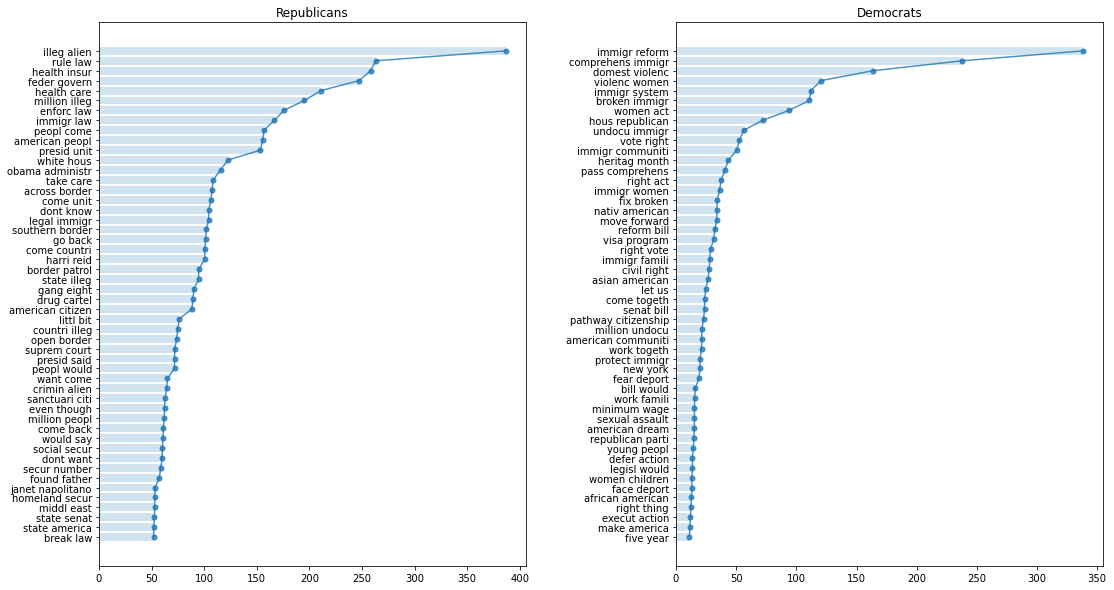

In [27]:
# Split the lists on republican, democrat membership
top_phrases_bi_R = top_phrases_bi.loc[top_phrases_bi['party'] == 'R']
top_phrases_bi_D = top_phrases_bi.loc[top_phrases_bi['party'] == 'D']

#Plot the top 50 bigrams
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,10))

# Variable parameters
phrases_plot_R = top_phrases_bi_R['phrase'].to_list()[-50:]
phrases_plot_D = top_phrases_bi_D['phrase'].to_list()[-50:]
chi2_plot_R = top_phrases_bi_R['chi2'].to_list()[-50:]
chi2_plot_D = top_phrases_bi_D['chi2'].to_list()[-50:]
x       = range(len(phrases_plot_R)) #Range going to 50

# Define plot
ax1.title.set_text('Republicans')
ax1.barh(x,chi2_plot_R, align='center', alpha=0.2)
ax1.plot(chi2_plot_R, x, '-o', markersize=5, alpha=0.8)
ax1.set_yticks(x)
ax1.set_yticklabels(phrases_plot_R)

ax2.title.set_text('Democrats')
ax2.barh(x,chi2_plot_D, align='center', alpha=0.2)
ax2.plot(chi2_plot_D, x, '-o', markersize=5, alpha=0.8)
ax2.set_yticks(x)
ax2.set_yticklabels(phrases_plot_D)

plt.subplots_adjust(wspace=0.35)

plt.show()

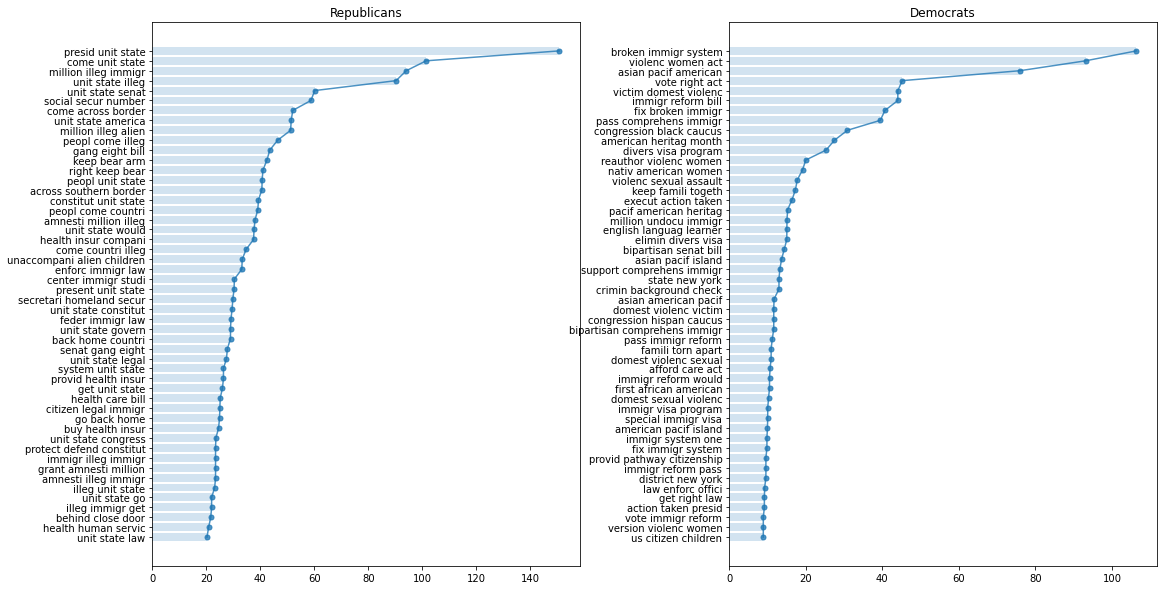

In [28]:
# Split the lists on republican, democrat membership
top_phrases_tri_R = top_phrases_tri.loc[top_phrases_tri['party'] == 'R']
top_phrases_tri_D = top_phrases_tri.loc[top_phrases_tri['party'] == 'D']

#Plot the top 50 trigrams
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,10))

# Variable parameters
phrases_plot_R = top_phrases_tri_R['phrase'].to_list()[-50:]
phrases_plot_D = top_phrases_tri_D['phrase'].to_list()[-50:]
chi2_plot_R = top_phrases_tri_R['chi2'].to_list()[-50:]
chi2_plot_D = top_phrases_tri_D['chi2'].to_list()[-50:]
x       = range(len(phrases_plot_R)) #Range going to 50

# Define plot
ax1.title.set_text('Republicans')
ax1.barh(x,chi2_plot_R, align='center', alpha=0.2)
ax1.plot(chi2_plot_R, x, '-o', markersize=5, alpha=0.8)
ax1.set_yticks(x)
ax1.set_yticklabels(phrases_plot_R)

ax2.title.set_text('Democrats')
ax2.barh(x,chi2_plot_D, align='center', alpha=0.2)
ax2.plot(chi2_plot_D, x, '-o', markersize=5, alpha=0.8)
ax2.set_yticks(x)
ax2.set_yticklabels(phrases_plot_D)

plt.subplots_adjust(wspace=0.35)

plt.show()

## Methodology: Step #3

- Use politicians' language and ideology to <font color='blue'>map phrases to ideology</font>
<br>

- Re-index the phrases in the sample by <font color='blue'>$p \in [1,\dots,1000]$</font>
<br>

- For each congressperson <font color='blue'>$c \in C$</font> we observe ideology <font color='blue'>$y_c$</font> and phrase frequencies <font color='blue'>$\{f_{pc}\}^{1000}_{p=1}$</font>
<br>

- Compute relative frequencies as <font color='blue'>$\tilde{f}_{p c}=f_{p c} / \sum_{p=1}^{P} f_{p c}$</font>
<br>

- For each phrase <font color='blue'>$p$</font>, we regress <font color='blue'>$\tilde{f}_{p c}$</font> on <font color='blue'>$y_c$</font> for the sample of congresspeople, obtaining an intercept and a slope parameter, <font color='blue'>$a_p$</font> and <font color='blue'>$b_p$</font>
<br>

- Hence we estimate 1,000 separate regressions, each with a sample the size of <font color='blue'>$C$</font>
<br>

- Intuition: the larger <font color='blue'>$b_p$</font>, the more the use of a phrase is correlated with ideology (<font color='blue'>$y_c$</font>)

In [29]:
# Create a copy of the speech_df
speeches = speech_df.copy()

# Keep only relevant columns
keep = ['speaker','party','preproc_speech']                                  # Define relevant columns
speeches = speeches[keep]                                                    # Dataframe slice
speeches['party'] = pd.get_dummies(speeches['party'].astype('category'))     # Define party as categorical

# Check handful of entries
speeches.head()

# Top phrases
top_phrases = pd.concat([top_phrases_bi,top_phrases_tri])

In [30]:
# Join all speeches that belong to the same Speaker x Party
speeches['preproc_speech'] = speeches.groupby(['speaker','party'])['preproc_speech'].transform(lambda x: ' '.join(x))

# Drop any duplicates, we only need one speaker x party observation with all speeches
speeches = speeches[['speaker','party','preproc_speech']].drop_duplicates().reset_index(drop = True)

# Count top phrase usage per congressperson
for phrase in tqdm(top_phrases['phrase']):
    speeches[phrase] = speeches['preproc_speech'].str.count(phrase)

# Establish frequency of top phrase usage
speeches.loc[:,'total'] = speeches.sum(axis=1)                              # Create column with total number of top phrases
speeches.iloc[:,3:] = speeches.iloc[:,3:].div(speeches.total,axis=0)        # Obtain relative frequencies
speeches = speeches.dropna(axis = 0).drop('total', axis=1)                  # Drop row NAs and the Total column

# Check handful of entries
speeches.head()

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.80it/s]


,speaker,party,preproc_speech,law make,hous bill,could help,central american,immigr make,need get,racial profil,issu face,program help,foreign worker,us go,state bill,us economi,senat immigr,say want,law school,statu liberti,would creat,nation immigr,brother sister,action immigr,civil war,border mexico,children immigr,live american,democrat republican,major american,year work,congress pass,elli island,born unit,one great,end meet,us immigr,immigr one,rais famili,said want,want know,chamber commerc,colleg student,immigr america,tea parti,judiciari committe,also includ,brought countri,justic system,congression district,local law,look forward,work us,us work,go colleg,abl get,american valu,immigr visa,men women,el paso,say would,senat democrat,three time,court rule,feder agenc,like see,pass away,bill go,driver licens,larg number,could use,support presid,enforc offici,immigr unit,border secur,across countri,tri make,american famili,care act,last week,immigr enforc,green card,week ago,crimin justic,senior citizen,first year,realli want,work peopl,air forc,everi time,one day,law allow,state could,washington post,less like,leav countri,work way,make differ,year presid,american cultur,feel like,polit parti,would see,north carolina,right law,resid unit,state new,thousand peopl,senat pass,usmexico border,would go,peopl live,los angel,member congress,better life,creat job,higher educ,good thing,im sure,last night,want get,percent american,public servic,million dollar,what happen,us citizen,program provid,remind us,human traffick,live work,obama execut,challeng face,day week,background check,public safeti,local govern,feder court,enter countri,terrorist attack,one mani,us congress,first place,immigr nation,pass senat,could make,state citizen,unit nation,enforc agenc,million immigr,afford care,end year,presid georg,open door,american work,introduc bill,reform would,state state,year later,next year,number illeg,right movement,latino immigr,nation guard,middl class,help peopl,south carolina,everi year,immigr debat,mani thing,world war,two three,immigr legal,sound like,around countri,secretari state,ten thousand,work go,us govern,pass immigr,peopl know,citizenship immigr,state law,immigr status,seem like,that go,one us,war ii,mani us,would make,want see,public school,immigr problem,one two,want make,way get,would like,work unit,nanci pelosi,unaccompani children,would give,mani time,want go,answer question,get us,told us,year go,border illeg,get back,wall street,el salvador,join us,support immigr,peopl work,dont understand,send messag,someth like,one person,god bless,across nation,commit crime,peopl see,school district,take job,five year,one reason,peopl countri,make america,way life,along way,time year,immigr servic,incom tax,put togeth,execut action,resid status,us border,elect presid,right thing,common sens,depart homeland,african american,capitol hill,need know,face deport,women children,york time,abraham lincoln,democrat parti,sent back,legisl would,defer action,town hall,job creat,foreign polici,chief justic,street journal,peopl dont,countri go,group peopl,young peopl,law requir,one would,thing go,feder law,republican parti,didnt know,last time,solv problem,american dream,sexual assault,minimum wage,district court,go home,time get,south america,work famili,hous senat,state hous,bill would,peopl get,enter unit,let go,path citizenship,law pass,could see,million american,took place,one time,state presid,enforc offic,law would,mani american,peopl think,central america,across state,unemploy rate,tri get,what go,immigr get,law go,around world,set asid,give us,peopl like,least one,would get,bill clinton,look back,first time,regard immigr,fear deport,look like,came unit,work permit,one side,bush administr,new york,protect immigr,mani peopl,use term,would put,nation world,would grant,ask question,billion dollar,dont like,month ago,work togeth,american communiti,declar independ,million undocu,would take,tell us,long time,came america,cant afford,h

#### - For each phrase <font color='blue'>$p$</font>, we regress <font color='blue'>$\tilde{f}_{p c}$</font> on <font color='blue'>$y_c$</font> for the sample of congresspeople, obtaining an intercept and a slope parameter, <font color='blue'>$a_p$</font> and <font color='blue'>$b_p$</font>
<br>

In [31]:
coefficients = []                                               # A list to fill

x = speeches['party'].values.reshape(-1,1)                      # Reshape Rep-Dem membership column to a column vector (R == 0)

for phrase in tqdm(top_phrases['phrase']):                      # Iterate over top phrases

    regr = LinearRegression()                                   # Define sklearn Linear Regression model
    
    regr.fit(x, speeches[phrase])                               # Regress phrase on membership
    
    alpha = regr.intercept_                                     # Store intercept
    beta  = regr.coef_[0]                                       # Store coefficient
    
    coefficients.append([phrase,alpha,beta])                    # Append as 3-item tuples to coefficients list

# Create dataframe
coefficients = pd.DataFrame(coefficients, columns=['phrase','alpha','beta'])

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1711.55it/s]


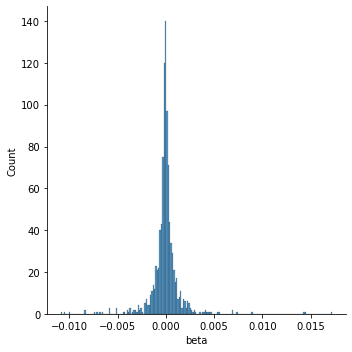

In [32]:
# Plot the distribution of coefficients(a negative beta implies higher word use among Republicans)
sns.displot(coefficients, x="beta")

In [33]:
# Five words with largest negative b coefficient (X_r == 0, X_d == 1)
coefficients.sort_values(by = 'beta')[:5]

,phrase,alpha,beta
493,health care,0.022751,-0.010878
495,feder govern,0.015200,-0.010544
428,presid obama,0.015679,-0.009967
490,immigr law,0.011616,-0.008358
487,american peopl,0.017054,-0.008332


In [34]:
# Five words with largest positive b coefficient
coefficients.sort_values(by = 'beta')[-5:]

,phrase,alpha,beta
313,new york,0.008316,0.007314
484,violenc women,0.002004,0.008936
494,comprehens immigr,0.000660,0.014236
489,domest violenc,0.001034,0.014395
498,immigr reform,0.006159,0.017214


## Methodology: Step #4

- We want to assign each paper a measure of slant based on the frequency of phrases it uses and their ideological valence
<br>

- For each paper <font color='blue'>$n \in N$</font>, we observe the relative frequency for each phrase <font color='blue'>$\tilde{f}_{pc}$</font>, but not the ideology <font color='blue'>$y_n$</font>, which we want to estimate
<br>

- For each newspaper <font color='blue'>$n$</font> we regress <font color='blue'>$\left(\tilde{f}_{p n}-a_{p}\right)$</font> on <font color='blue'>$b_p$</font> for the sample of phrases, obtaining the slope estimate

$$\hat{y}_{n}=\frac{\sum_{p=1}^{1000} b_{p}\left(\tilde{f}_{p n}-a_{p}\right)}{\sum_{p=1}^{1000} b_{p}^{2}}$$

- We estimate <font color='blue'>$N$</font> separate regressions, each with a sample of 1,000
<br>

- Intuition: the higher the frequency (<font color='blue'>$\tilde{f}_{pn}$</font>) of more ideological phrases (<font color='blue'>$b_p$</font>), the higher the measure of slant (<font color='blue'>$\hat{y}_n$</font>)

In [35]:
# Create a copy of the df_processed_np
newspapers = df_processed_np.copy()

# Define relevant columns and create dataframe slice
keep = ['year','NPNAME1','preproc_nl_articles']
newspapers = newspapers[keep]

In [36]:
# Concatenate all year-and-newspaper-specific articles
newspapers['preproc_nl_articles'] = newspapers.groupby(['NPNAME1','year'])['preproc_nl_articles'].transform(lambda x: ' '.join(x))
newspapers = newspapers[['year','NPNAME1','preproc_nl_articles']].drop_duplicates().reset_index(drop = True)

# Iterate over top phrases and count phrase instances
for phrase in tqdm(top_phrases['phrase']):
    newspapers[phrase] = newspapers['preproc_nl_articles'].str.count(phrase)
    
# Create total top phrases usage column
newspapers.loc[:,'total'] = newspapers.drop('year', axis=1).sum(axis=1)

# Create relative frequencies
newspapers.iloc[:,3:] = newspapers.iloc[:,3:].div(newspapers.total,axis=0)           # Obtain relative frequencies
newspapers = newspapers.dropna(axis = 0).drop('total', axis=1)                       # Drop row NAs and the Total column

# Check handful of entries
newspapers.head()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:29<00:00,  6.69it/s]


,year,NPNAME1,preproc_nl_articles,law make,hous bill,could help,central american,immigr make,need get,racial profil,issu face,program help,foreign worker,us go,state bill,us economi,senat immigr,say want,law school,statu liberti,would creat,nation immigr,brother sister,action immigr,civil war,border mexico,children immigr,live american,democrat republican,major american,year work,congress pass,elli island,born unit,one great,end meet,us immigr,immigr one,rais famili,said want,want know,chamber commerc,colleg student,immigr america,tea parti,judiciari committe,also includ,brought countri,justic system,congression district,local law,look forward,work us,us work,go colleg,abl get,american valu,immigr visa,men women,el paso,say would,senat democrat,three time,court rule,feder agenc,like see,pass away,bill go,driver licens,larg number,could use,support presid,enforc offici,immigr unit,border secur,across countri,tri make,american famili,care act,last week,immigr enforc,green card,week ago,crimin justic,senior citizen,first year,realli want,work peopl,air forc,everi time,one day,law allow,state could,washington post,less like,leav countri,work way,make differ,year presid,american cultur,feel like,polit parti,would see,north carolina,right law,resid unit,state new,thousand peopl,senat pass,usmexico border,would go,peopl live,los angel,member congress,better life,creat job,higher educ,good thing,im sure,last night,want get,percent american,public servic,million dollar,what happen,us citizen,program provid,remind us,human traffick,live work,obama execut,challeng face,day week,background check,public safeti,local govern,feder court,enter countri,terrorist attack,one mani,us congress,first place,immigr nation,pass senat,could make,state citizen,unit nation,enforc agenc,million immigr,afford care,end year,presid georg,open door,american work,introduc bill,reform would,state state,year later,next year,number illeg,right movement,latino immigr,nation guard,middl class,help peopl,south carolina,everi year,immigr debat,mani thing,world war,two three,immigr legal,sound like,around countri,secretari state,ten thousand,work go,us govern,pass immigr,peopl know,citizenship immigr,state law,immigr status,seem like,that go,one us,war ii,mani us,would make,want see,public school,immigr problem,one two,want make,way get,would like,work unit,nanci pelosi,unaccompani children,would give,mani time,want go,answer question,get us,told us,year go,border illeg,get back,wall street,el salvador,join us,support immigr,peopl work,dont understand,send messag,someth like,one person,god bless,across nation,commit crime,peopl see,school district,take job,five year,one reason,peopl countri,make america,way life,along way,time year,immigr servic,incom tax,put togeth,execut action,resid status,us border,elect presid,right thing,common sens,depart homeland,african american,capitol hill,need know,face deport,women children,york time,abraham lincoln,democrat parti,sent back,legisl would,defer action,town hall,job creat,foreign polici,chief justic,street journal,peopl dont,countri go,group peopl,young peopl,law requir,one would,thing go,feder law,republican parti,didnt know,last time,solv problem,american dream,sexual assault,minimum wage,district court,go home,time get,south america,work famili,hous senat,state hous,bill would,peopl get,enter unit,let go,path citizenship,law pass,could see,million american,took place,one time,state presid,enforc offic,law would,mani american,peopl think,central america,across state,unemploy rate,tri get,what go,immigr get,law go,around world,set asid,give us,peopl like,least one,would get,bill clinton,look back,first time,regard immigr,fear deport,look like,came unit,work permit,one side,bush administr,new york,protect immigr,mani peopl,use term,would put,nation world,would grant,ask question,billion dollar,dont like,month ago,work togeth,american communiti,declar independ,million undocu,would take,tell us,long time,came america,cant affo

In [37]:
# Reshape to long
np_coeff = newspapers.drop('preproc_nl_articles', axis=1)
np_coeff = pd.melt(np_coeff, id_vars=['NPNAME1','year'], var_name='phrase')

# Check handful of entries
np_coeff.head(20)

,NPNAME1,year,phrase,value
0,abilenereporternewsTX,2009,law make,0.0
1,fremontargusCA,2009,law make,0.0
2,littlerockarkansasdemocratgazetteAR,2009,law make,0.0
3,atlantajournalconstitutionGA,2009,law make,0.0
4,bostonheraldMA,2009,law make,0.0
5,brattlebororeformerVT,2009,law make,0.0
6,brownsvilleheraldTX,2009,law make,0.0
7,chattanoogatimesfreepressTN,2009,law make,0.0
8,cumberlandtimesnewsMD,2009,law make,0.0
9,arlingtonheightsdailyheraldIL,2009,law make,0.0


In [39]:
year_newspaper_slant = []                                                    # Create list to feed

for newspaper in tqdm(list(np_coeff.NPNAME1.unique())):                      # Iterate over all unique newspaper names
    
    for year in range(2009, 2018):                                           # Iterate for every year
        
        # Create temp df slice corresponding to newspaper i in year j
        temp_df = np_coeff.loc[(np_coeff['NPNAME1'] == newspaper) & (np_coeff['year'] == year)]
        
        if len(temp_df) == 0:                                                # If newspaper doesn't exist, skip
            pass
        else:
            freq  = temp_df['value'].values.reshape(-1,1)                    # column vector with relative top phrase freq
            alpha = coefficients['alpha'].values.reshape(-1,1)               # column vector with phrase intercepts

            y     = freq - alpha                                             # dependent variable
            beta  = coefficients['beta'].values.reshape(-1,1)                # independent variable - coefficients of 'ideology'

            regr.fit(beta, y)                                                # regress y on x

            slant = regr.coef_[0][0]                                         # obtain coefficient: our measure of np slant

            year_newspaper_slant.append(tuple([year,newspaper,slant]))       # Append to list

# Create dataframe with all year-newspaper-specific measures of slant
np_slant = pd.DataFrame(year_newspaper_slant, columns = ['year','newspaper','slant'])

100%|██████████████████████████████████████████████████████████████████████████████| 766/766 [1:00:27<00:00,  4.74s/it]


In [40]:
# Check handful of entries
np_slant.head(20)

,year,newspaper,slant
0,2009,abilenereporternewsTX,0.976469
1,2010,abilenereporternewsTX,0.797702
2,2011,abilenereporternewsTX,0.451766
3,2012,abilenereporternewsTX,0.337670
4,2013,abilenereporternewsTX,0.776279
5,2014,abilenereporternewsTX,0.624676
6,2015,abilenereporternewsTX,0.533099
7,2016,abilenereporternewsTX,0.366188
8,2017,abilenereporternewsTX,0.392308
9,2009,fremontargusCA,0.527565


In [41]:
# Cross-section average
nl_all_slant = pd.DataFrame(np_slant.groupby('newspaper')['slant'].mean().reset_index())

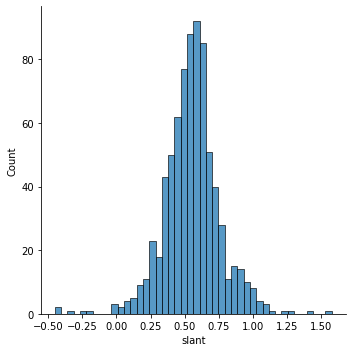

In [42]:
# Plot newspaper-specific slant measures
sns.displot(nl_all_slant, x="slant")

In [43]:
# Five top Republican-leaning newspapers
nl_all_slant.sort_values(by = 'slant')[:5]

,newspaper,slant
279,greenevillesunTN,-0.451178
45,bakercityheraldOR,-0.423052
497,newportplaintalkTN,-0.349129
618,sandpointbonnercountydailybeeID,-0.237088
647,shenandoahvalleynewstodayIA,-0.187495


In [44]:
# Five bottom Republican-leaning newspapers
nl_all_slant.sort_values(by = 'slant')[-5:]

,newspaper,slant
571,pratttribuneKS,1.118923
413,madisoncourierIN,1.240287
423,mariannajacksoncountyfloridanFL,1.298532
362,lagrandeobserverOR,1.435895
748,willoughbynewsheraldOH,1.575411


# Paper main takeaways

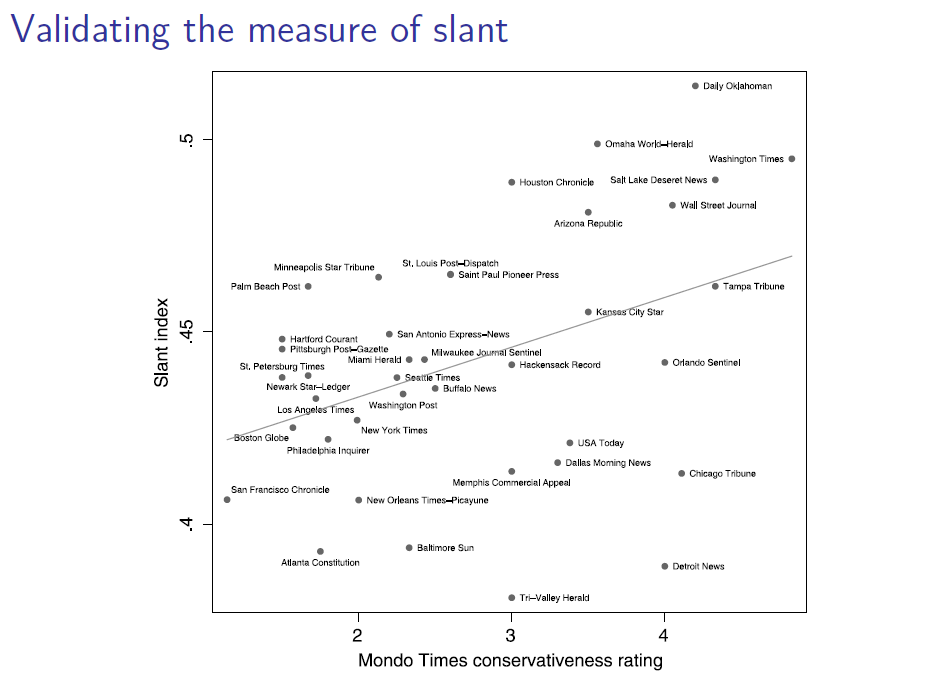
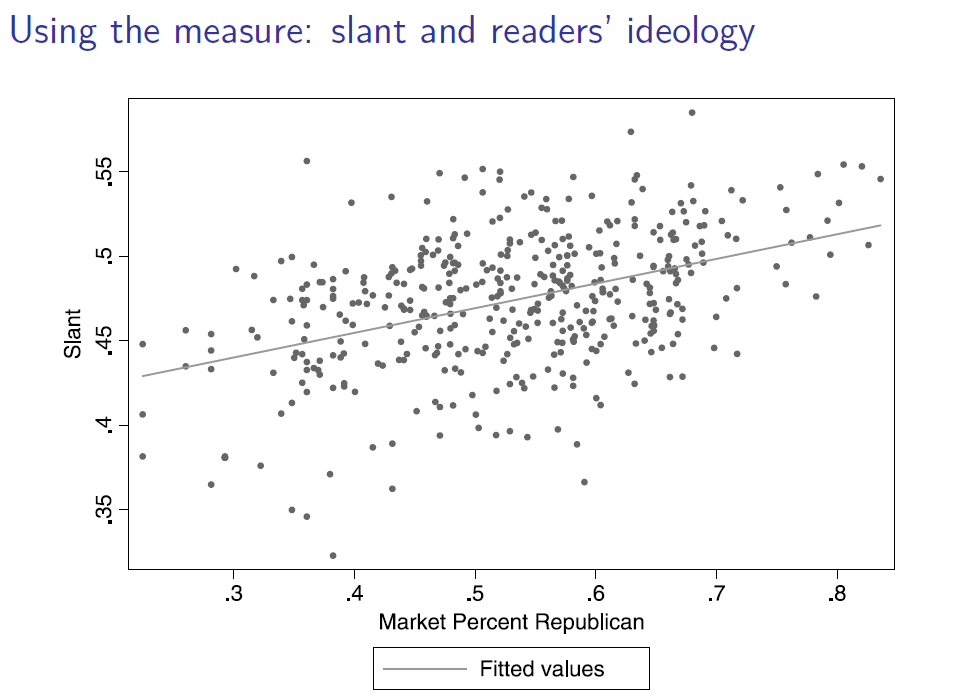

## Media Slant

We will now compute a immigration-specific measure of media slant of NewsLibrary articles released yearly. The objective is to replicate the method developed by Gentzkow and Shapiro (2010).

The process below can be summarized in a series of steps:

1 - Of the 500 phrases that are most predictive of the speakers' affiliation to the Republican party, the code keeps the ones encountered in NewsLibrary articles at least 10 times (these result in 369 phrases)

2 - For each phrase _p_ and each congressperson _c_, the code computes the
	relative frequency of the phrase in Congressional speech

3 - The code then regresses the relative frequency on an indicator for the 
	congressperson's party, obtaining phrase-specific intercept and slope 
	coefficients _a_ and _b_
    
		- # Regresions   = # Top Phrases
		- # Observations = # Congresspeople

4 - Next, the code computes the relative frequency of each phrase in NewsLibrary
	articles released in a given year.

5 - Finally, for each newspaper we regress its relative immigrant-related phrase frequency (substracting _a_) on all phrase-specific _b_ obtained above (measures
	the phrase's ideological load). The resulting coeficient estimates reflect
	the time-varying measure of slant.